# Triggering observation of ANTARES locus objects with TOM


**This notebook requires the installation of ANTARES client (https://noao.gitlab.io/antares/client/) and TOMtoolkit (https://tom-toolkit.readthedocs.io/en/latest/introduction/getting_started.html#installing-the-tom-toolkit-and-django). For more detail on programmatic access of TOMtoolkit, please see (https://tom-toolkit.readthedocs.io/en/stable/common/scripts.html).**


We can arrange follow up observations of intriguing ANTARES locus/alert using the facilities within the Astronomical Event Observatory Network (AEON). This can be conviently done with the TOMtoolkit as follows.

The first step is to define the target information (name, ra, dec, etc.)

In [1]:
from antares_client.search import get_by_id, get_by_ztf_object_id
#get locus by ANTARES ID
locus = get_by_id("ANT2018c7igm")

#get locus by ZTF ID
#locus = get_by_ztf_id("ZTF18abhjrcf")

print(locus.locus_id, locus.ra, locus.dec)

import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
from tom_targets.models import Target
t = Target.objects.create(name=locus.locus_id, type='SIDEREAL', ra=locus.ra, dec=locus.dec)

ANT2018c7igm 280.69272450119047 -12.904123628571426


The next step is to populate the observation form

In [2]:
from tom_observations.facilities.gemini import GEMFacility, GEMObservationForm

target = Target.objects.get(name=locus.locus_id)

if target.dec < 0.0:
    obsid = 'GS-2019A-TOO-1-2'
else:
    obsid = 'GN-2019A-TOO-1-1'

form = GEMObservationForm({
    'target_id': target.id,
    'obsid': [ obsid ],
    'ready': 'true',
    'posangle': 0.,
    'exptimes': '',
    'brightness': None,
    'group': 'ANTARES',
    'note': '',
    'window_start': '',
    'eltype': 'none',
    'gstarg': '',
})          

We can check if there is any error of the observation form using form.is_valid()

In [3]:
form.is_valid()

True

Once the form is validated, we can submit it using the following command:

In [5]:
observation_ids = GEMFacility().submit_observation(form.observation_payload())

print(observation_ids)

['11']


/Users/miniconda2/envs/tom_env/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'gsodbtest.gemini.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



We can also create a record of the observation request

In [6]:
from tom_observations.models import ObservationRecord
for observation_id in observation_ids:
    print(observation_id + ' triggered!')
    record = ObservationRecord.objects.create(
        target=target,
        facility='GEM',
        parameters=form.serialize_parameters(),
        observation_id=observation_id
    )
    print(record)

Observation change state hook: ANT2018c7igm @ GEM from None to 


11 triggered!
ANT2018c7igm @ GEM


Now we can see a pending observation in TOM

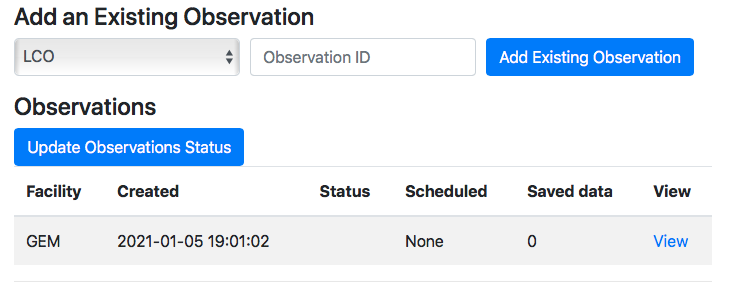

We can also see the observation request in the Gemini OT:

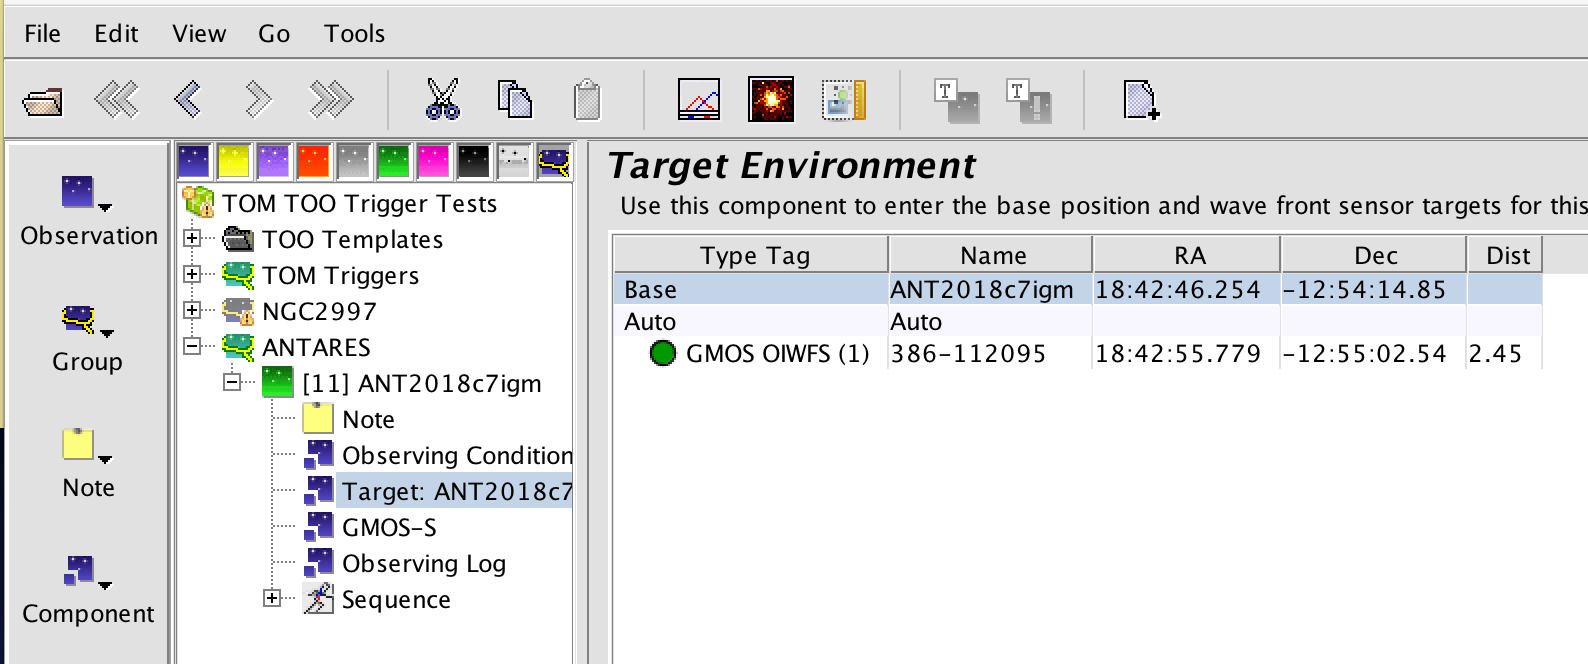